In [1]:
import os
import cv2
import numpy as np
from skimage import io, color
import matplotlib.pyplot as plt

In [2]:
movie_file = '/Users/jonaheaton/Documents/hulahoop_data/videos/DSC_7450.MOV'

In [ ]:
192,125,92
180, 105, 73
255, 162, 78
255, 185, 146
255, 181, 131
255, 159, 102
181, 129, 109
255, 176, 161
250, 171, 129
237, 178, 151
255, 171, 124



In [291]:

def display_channels(image):
    # Split the image into its color channels
    channels = cv2.split(image)

    # Create a figure and subplots
    fig, axs = plt.subplots(2, 3, figsize=(20, 20))

    # Display each channel and its histogram
    for i, ax in enumerate(axs[0]):
        ax.imshow(channels[i], cmap='gray')
        ax.set_title(f'Channel {i}')

    for i, ax in enumerate(axs[1]):
        ax.hist(channels[i].ravel(), bins=256, color='gray')
        ax.set_yscale('log')
        ax.set_title(f'Channel {i} Histogram')

    plt.tight_layout()
    plt.show()



def basic_process_frame(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    return frame
    # split the frame into a bottom and top half

def split_frame(frame):
    height, width, _ = frame.shape
    top_half = frame[0:800, :]
    bottom_half = frame[800:, :]

    return top_half, bottom_half
   
   

# 192,125,92
# 180, 105, 73
# 255, 162, 78
# 255, 185, 146
# 255, 181, 131
# 255, 159, 102
# 181, 129, 109
# 255, 176, 161
# 250, 171, 129
# 237, 178, 151
# 255, 171, 124



def get_orange_hoop_mask(img):
    # Define the lower and upper boundaries for the color orange in the RGB color space
    lower_orange = np.array([190, 100, 70]) # RGB
    # lower_orange = np.array([180, 80, 50]) # RGB
    upper_orange = np.array([255, 200, 165]) # RGB

    # Create a mask for the color orange
    mask = cv2.inRange(img, lower_orange, upper_orange)

    # Optional: Apply dilation to the mask to remove noise
    kernel = np.ones((3,3), np.uint8)
    # kernel = np.ones((5,5), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations = 1)
    return mask
    # Bitwise-AND the mask and the original image
    segmented_image = cv2.bitwise_and(img, img, mask=mask)
    return segmented_image


def get_black_hoop_mask(img, orange_mask,box_sz=300):
    '''
    Given top or bottom half of the image
    find the center of mass of the orange mask
    create a rectangle around the center of mass
    within the rectangle find the black hoop masks
    '''
    center = get_center_of_mass(orange_mask)
    box = get_box_from_center(center, box_sz,box_sz)
    x, y, w, h = box
    roi = img[y:y+h, x:x+w]
    
    black_mask_roi = cv2.inRange(roi, np.array([0,0,0]), np.array([50,50,110]))

    # Create a black mask for the full image
    black_mask_full = np.zeros(img.shape[:2], dtype=np.uint8)
    # black_mask_full = np.zeros_like(img)
    
    # Apply the mask from the ROI to the corresponding location in the full image mask
    black_mask_full[y:y+h, x:x+w] = black_mask_roi

    # Optional: Apply dilation to the mask to remove noise
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.dilate(black_mask_full, kernel, iterations = 1)

    return mask


def get_hoop_markers(img,hoop_mask=None):
    if hoop_mask is None:
        hoop_mask = get_orange_hoop_mask(img)

    black_mask = get_black_hoop_mask(img, hoop_mask)
    black_mask = remove_large_connected_components(black_mask, 300)
    black_mask = remove_small_connected_components(black_mask, 20)
    return black_mask

def get_hoop_mask(img):
    '''
    Find the orange mask
    find the black mask
    combine the masks
    '''
    orange_mask = get_orange_hoop_mask(img)
    hoop_markers = get_hoop_markers(img, orange_mask)
    hoop_mask = cv2.bitwise_or(orange_mask, hoop_markers)
    return hoop_mask

def get_center_of_mass(mask):
    '''
    Find the center of mass of the mask
    '''
    moments = cv2.moments(mask)
    cX = int(moments["m10"] / moments["m00"])
    cY = int(moments["m01"] / moments["m00"])
    return (cX, cY)

def get_box_from_center(center, width, height):
    '''
    Create a box of given width and height around the center
    '''
    x = max(0, center[0] - width // 2)
    y = max(0, center[1] - height // 2)
    return (x, y, width, height)

def get_connected_components(mask):
    '''
    Find the connected components of the mask
    '''
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    return num_labels, labels, stats, centroids

def get_area_of_mask(mask):
    '''
    Calculate the area of the mask
    '''
    return cv2.countNonZero(mask)


def remove_large_connected_components(mask, max_area):
    '''
    Remove connected components that are larger than the max area
    '''
    num_labels, labels, stats, centroids = get_connected_components(mask)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] > max_area:
            mask[labels == i] = 0
    return mask

def remove_small_connected_components(mask, min_area):
    '''
    Remove connected components that are smaller than the min area
    '''
    num_labels, labels, stats, centroids = get_connected_components(mask)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] < min_area:
            mask[labels == i] = 0
    return mask


def get_object_centroids(mask):
    '''
    Find the centroids of the connected components in the mask
    '''
    num_labels, labels, stats, centroids = get_connected_components(mask)
    return centroids[1:]

def get_object_centroids_and_areas(mask):
    '''
    Find the centroids and areas of the connected components in the mask
    '''
    num_labels, labels, stats, centroids = get_connected_components(mask)
    return centroids[1:], stats[1:, cv2.CC_STAT_AREA]


def remove_stationay_objects(mask, bad_centroids, dist_th=50):
    '''
    Remove connected components that are smaller than the min area and have centroids close to the bad centroids
    '''

    num_labels, labels, stats, centroids = get_connected_components(mask)
    for i in range(1, num_labels):
        # if stats[i, cv2.CC_STAT_AREA] < threshold:
        for bad_centroid in bad_centroids:
            if np.linalg.norm(bad_centroid - centroids[i]) < 50:
                mask[labels == i] = 0
                break

    return mask

def get_hoop_circle_from_mask(mask):
    circles = cv2.HoughCircles(mask, cv2.HOUGH_GRADIENT, dp=10, minDist=200, param1=300, param2=0.95, minRadius=80, maxRadius=100)
        # If at least one circle is detected
    if circles is not None:
        circles = np.uint16(np.around(circles))
        return circles[0]
    return None



def fit_ellipse_to_disjoint_masks(mask,min_area=50):
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    # remove small contours
    contours = [c for c in contours if cv2.contourArea(c) > min_area]
    # Concatenate all the contours into a single array
    all_points = np.concatenate(contours)

    # Ensure there are at least 5 points (required to fit an ellipse)
    if len(all_points) >= 5:
        # Fit an ellipse to the points
        ellipse = cv2.fitEllipse(all_points)
        return ellipse

    return None


def get_ellipse_mask(image, ellipse, thickness=20):
    ellipse_image = np.zeros_like(image)
    cv2.ellipse(ellipse_image, ellipse, (255, 255, 255), thickness)
    return ellipse_image


def find_near_ellipse_markers(image, ellipse, thickness=20,min_area=20):
    ellipse_image = get_ellipse_mask(image, ellipse, thickness=thickness)
    # Perform a bitwise AND operation between the ellipse image and the original image
    near_ellipse_pixels = cv2.bitwise_and(image, ellipse_image)

    # Convert to HSB color space
    hsv = cv2.cvtColor(near_ellipse_pixels, cv2.COLOR_RGB2HSV_FULL)

    # Create a mask of the pixels within the specified range
    lower_bound = np.array([150, 70, 0])
    # upper_bound = np.array([250,255, 150])
    upper_bound = np.array([200,255, 150])
    mask = cv2.inRange(hsv, lower_bound, upper_bound)
    # remove small connected components
    mask = remove_small_connected_components(mask, min_area)
    # dilate the mask
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations = 1)
    return mask



# works for the bottom half
def complete_circle(mask):
    # Ensure the mask is a grayscale image
    assert len(mask.shape) == 2

    # Blur the image to reduce noise
    # gray = cv2.medianBlur(mask, 5)

    # Use the HoughCircles function to detect circles
    circles = cv2.HoughCircles(mask, cv2.HOUGH_GRADIENT, dp=10, minDist=200, param1=300, param2=0.95, minRadius=80, maxRadius=100)
    # circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=0, maxRadius=0)

    # Create a 3-channel image from the mask
    image = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    # If at least one circle is detected
    if circles is not None:
        circles = np.uint16(np.around(circles))

        # Draw each circle
        for i in circles[0, :]:
            # Draw the outer circle
            cv2.circle(image, (i[0], i[1]), i[2], (0, 255, 0), 2)
            # Draw the center of the circle
            cv2.circle(image, (i[0], i[1]), 2, (0, 0, 255), 3)

    return image

def overlay_mask(image, mask, color=(0, 255, 0), alpha=0.5):
    # Ensure the mask is a grayscale image
    assert len(mask.shape) == 2

    # Create a 3-channel version of the mask
    mask_color = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    # Set the color of the mask
    mask_color[mask != 0] = color

    # Blend the original image with the color mask
    overlay = cv2.addWeighted(image, 1 - alpha, mask_color, alpha, 0)

    return overlay

In [290]:
top_half_bad_centroids = [[370.2    , 360.78461538],
                        [379.86419753, 626.51851852]]


def process_frame(frame):
    top_half, bottom_half = split_frame(frame)
    
    top_hoop_mask = get_orange_hoop_mask(top_half)
    bottom_hoop_mask = get_orange_hoop_mask(bottom_half)

    bottom_circle = None
    # bottom_circle = get_hoop_circle_from_mask(bottom_hoop_mask)
    bottom_ellipse=fit_ellipse_to_disjoint_masks(bottom_hoop_mask,min_area=20)
    top_ellipse = fit_ellipse_to_disjoint_masks(top_hoop_mask)

    top_overlay = overlay_mask(top_half, top_hoop_mask)
    bottom_overlay = overlay_mask(bottom_half, bottom_hoop_mask)

    if bottom_circle is not None:
        bottom_circle = bottom_circle[0]
        cv2.circle(bottom_overlay, (bottom_circle[0], bottom_circle[1]), bottom_circle[2], (255, 255, 0), 2)
        cv2.circle(bottom_overlay, (bottom_circle[0], bottom_circle[1]), 2, (255, 0, 255), 3)

    if bottom_ellipse is not None:
        cv2.ellipse(bottom_overlay, bottom_ellipse, (255, 255, 0), 2)

    if top_ellipse is not None:
        cv2.ellipse(top_overlay, top_ellipse, (255, 255, 0), 2)
        

    top_markers = find_near_ellipse_markers(top_half, top_ellipse)
    bottom_markers = find_near_ellipse_markers(bottom_half, bottom_ellipse,thickness=10,min_area=5)

    # create a new overlay with the markers
    top_overlay = overlay_mask(top_overlay, top_markers,color=(255,0,0))
    bottom_overlay = overlay_mask(bottom_overlay, bottom_markers,color=(255,0,0))
    

    top_marker_centroids, top_marker_areas = get_object_centroids_and_areas(top_markers)
    bottom_marker_centroids, bottom_marker_areas = get_object_centroids_and_areas(bottom_markers)

    coordinate_dict = {
        'top_ellipse': top_ellipse,
        'bottom_ellipse': bottom_ellipse,
        'top_markers': top_marker_centroids,
        'bottom_markers': bottom_marker_centroids,
        'top_marker_area': top_marker_areas,
        'bottom_marker_area': bottom_marker_areas
    }


    # top_hoop_mask = get_hoop_mask(top_half)
    # bottom_hoop_mask = get_hoop_mask(bottom_half)
    
    # top_hoop_mask = remove_stationay_objects(top_hoop_mask, top_half_bad_centroids)
    # top_hoop_image = complete_circle(top_hoop_mask)
    # bottom_hoop_image = complete_circle(bottom_hoop_mask)


    combined_overlay = np.vstack([top_overlay, bottom_overlay])
    return combined_overlay, coordinate_dict

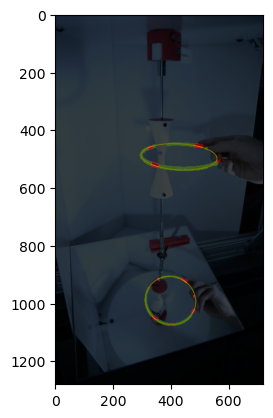

In [292]:
cap = cv2.VideoCapture('/Users/jonaheaton/Documents/hulahoop_data/videos/DSC_7450.MOV')



try:
    while True:
        # Read the next frame
        ret, frame = cap.read()
        if not ret:
            # We reached the end of the video
            break

        # Process the frame
        frame = basic_process_frame(frame)
        processed_frame, coordinate_dict = process_frame(frame)

        break

        # You can add code here to do something with the processed frame

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Release the video capture object
    cap.release()

# Display the processed frame
plt.imshow(processed_frame)

In [293]:
coordinate_dict

{'top_ellipse': ((429.06927490234375, 493.4830017089844),
  (90.46410369873047, 263.0711975097656),
  92.67453002929688),
 'bottom_ellipse': ((399.69061279296875, 190.78892517089844),
  (165.65542602539062, 175.75173950195312),
  114.62725830078125),
 'top_markers': array([[496.30655391, 455.78435518],
        [329.79087452, 461.11026616],
        [566.5234375 , 508.3359375 ],
        [345.84682713, 521.87089716]]),
 'bottom_markers': array([[357.77464789, 117.84507042],
        [447.30769231, 120.94871795],
        [480.63157895, 176.31578947],
        [477.27878788, 227.65454545],
        [346.0660793 , 251.52863436]]),
 'top_marker_area': array([473, 263, 128, 457], dtype=int32),
 'bottom_marker_area': array([ 71, 234,  57, 165, 227], dtype=int32)}

In [314]:
def parse_coordinate_dict(coordinate_dict,frame_num):
    top_ellipse = coordinate_dict['top_ellipse']
    bottom_ellipse = coordinate_dict['bottom_ellipse']
    top_markers = coordinate_dict['top_markers']
    bottom_markers = coordinate_dict['bottom_markers']
    top_marker_area = coordinate_dict['top_marker_area']
    bottom_marker_area = coordinate_dict['bottom_marker_area']


    # create a dictionary of the coordinates
    top_ellipse_x = top_ellipse[0][0]
    top_ellipse_y = top_ellipse[0][1]
    bottom_ellipse_x = bottom_ellipse[0][0]
    bottom_ellipse_y = bottom_ellipse[0][1]
    top_markers_x = [x for x, y in top_markers]
    top_markers_y = [y for x, y in top_markers]
    bottom_markers_x = [x for x, y in bottom_markers]
    bottom_markers_y = [y for x, y in bottom_markers]
    top_markers_area = top_marker_area
    bottom_markers_area = bottom_marker_area

    if len(top_markers_x) > 4:
        # eliminate the smallest marker, probably not the best way to do this
        min_idx = np.argmin(top_markers_area)
        top_markers_x.pop(min_idx)
        top_markers_y.pop(min_idx)
        top_markers_area.pop(min_idx)

    if len(bottom_markers_x) > 4:
        # eliminate the smallest marker
        min_idx = np.argmin(bottom_markers_area)
        bottom_markers_x.pop(min_idx)
        bottom_markers_y.pop(min_idx)
        bottom_markers_area.pop(min_idx)


    ellipse_coor = {
        'frame': frame_num,
        'top_ellipse_x': top_ellipse_x,
        'top_ellipse_y': top_ellipse_y,
        'bottom_ellipse_x': bottom_ellipse_x,
        'bottom_ellipse_y': bottom_ellipse_y
    }

    top_marker_coor = {
        'frame': frame_num*np.ones_like(top_markers_x),
        'top_markers_x': top_markers_x,
        'top_markers_y': top_markers_y,
        'top_markers_area': top_markers_area,
    }

    bottom_marker_coor = {
        'frame': frame_num*np.ones_like(bottom_markers_x),
        'bottom_markers_x': bottom_markers_x,
        'bottom_markers_y': bottom_markers_y,
        'bottom_markers_area': bottom_markers_area
    }

    return ellipse_coor, top_marker_coor, bottom_marker_coor

In [250]:
top_half, bottom_half = split_frame(frame)

bottom_mask = get_orange_hoop_mask(bottom_half)
ellipse = fit_ellipse_to_disjoint_masks(bottom_mask)


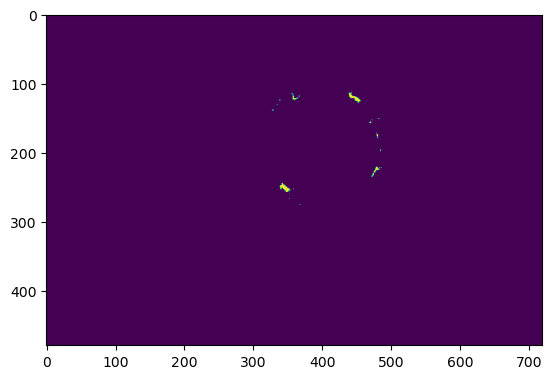

In [273]:
# Create a blank image of the same size as the original image
thickness = 15
image = bottom_half
ellipse_image = np.zeros_like(image)


# Draw the ellipse outline on the blank image with a thickness of 10 pixels
cv2.ellipse(ellipse_image, ellipse, (255, 255, 255), thickness)

# Perform a bitwise AND operation between the ellipse image and the original image
near_ellipse_pixels = cv2.bitwise_and(image, ellipse_image)

hsv = cv2.cvtColor(near_ellipse_pixels, cv2.COLOR_RGB2HSV_FULL)

# Create a mask of the pixels within the specified range
lower_bound = np.array([0, 120, 0])
upper_bound = np.array([290,255, 251])


lower_bound = np.array([150, 70, 0])
upper_bound = np.array([200,255, 150])


# lower_bound = np.array([0, 1, 0])
# upper_bound = np.array([100,120, 150])

# mask = cv2.inRange(hsv, lower_bound, upper_bound)

mask = cv2.inRange(hsv, lower_bound, upper_bound)

# plt.imshow(near_ellipse_pixels)
plt.imshow(mask)

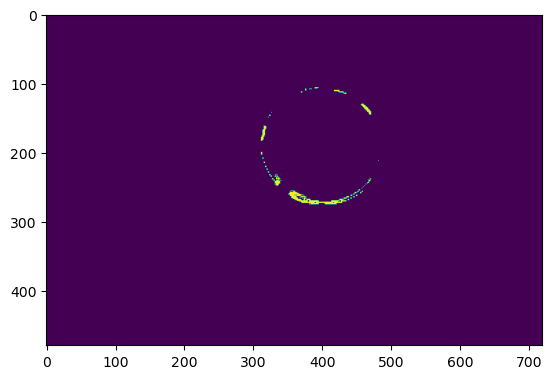

In [243]:
plt.imshow(mask)

In [120]:
top_half, bottom_half = split_frame(frame)

top_mask = get_orange_hoop_mask(top_half)

# mask = get_orange_hoop_mask(bottom_half)
# black_markers = get_hoop_markers(bottom_half, mask)

# plt.imshow(black_markers)

In [121]:
top_mask = get_orange_hoop_mask(top_half)
ellipse = fit_ellipse_to_disjoint_masks(top_mask)

In [122]:
ellipse

((429.06927490234375, 493.4830017089844),
 (90.46410369873047, 263.0711975097656),
 92.67453002929688)

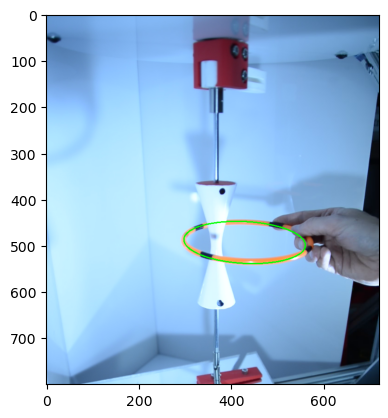

In [123]:
# plot the ellipse
ellipse_image = top_half.copy()
cv2.ellipse(ellipse_image, ellipse, (0, 255, 0), 2)
plt.imshow(ellipse_image)

In [166]:
# Create a blank image of the same size as the original image
thickness = 20
image = top_half
ellipse_image = np.zeros_like(image)


# Draw the ellipse outline on the blank image with a thickness of 10 pixels
cv2.ellipse(ellipse_image, ellipse, (255, 255, 255), thickness)

# Perform a bitwise AND operation between the ellipse image and the original image
near_ellipse_pixels = cv2.bitwise_and(image, ellipse_image)

# Create a mask of the pixels within the specified range
lower_bound = np.array([1, 1, 1])
upper_bound = np.array([85, 85, 130])
mask = cv2.inRange(near_ellipse_pixels, lower_bound, upper_bound)



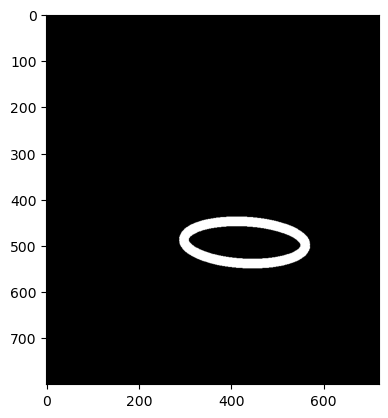

In [167]:
plt.imshow(ellipse_image)

False

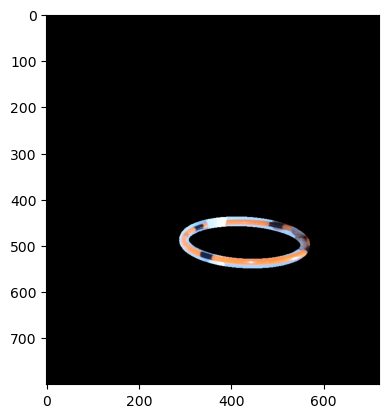

In [168]:
plt.imshow(near_ellipse_pixels)
# save the image
cv2.imwrite('~/Desktop/ellipse_image.png', ellipse_image)

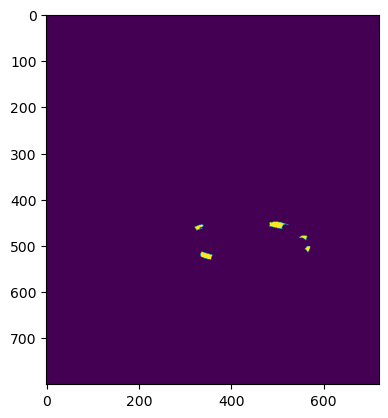

In [169]:
plt.imshow(mask)

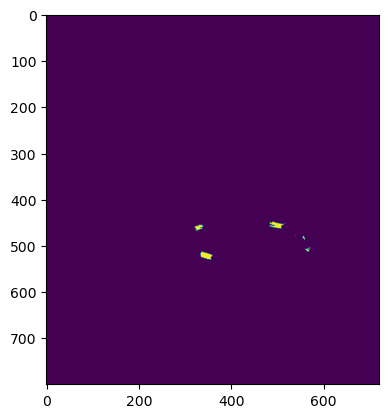

In [224]:
# Create a blank image of the same size as the original image
thickness = 20
image = top_half
ellipse_image = np.zeros_like(image)


# Draw the ellipse outline on the blank image with a thickness of 10 pixels
cv2.ellipse(ellipse_image, ellipse, (255, 255, 255), thickness)

# Perform a bitwise AND operation between the ellipse image and the original image
near_ellipse_pixels = cv2.bitwise_and(image, ellipse_image)

# Convert to HSB color space
hsv = cv2.cvtColor(near_ellipse_pixels, cv2.COLOR_RGB2HSV_FULL)

# Create a mask of the pixels within the specified range
lower_bound = np.array([150, 70, 0])
upper_bound = np.array([250,255, 150])
mask = cv2.inRange(hsv, lower_bound, upper_bound)

plt.imshow(mask)

In [181]:
hsv.shape

(800, 720, 3)

In [202]:
hsv[:,:,2].max()

255

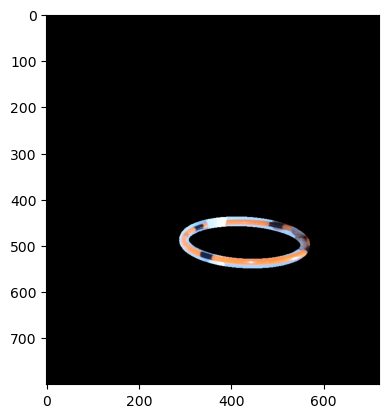

In [178]:
plt.imshow(near_ellipse_pixels)

In [124]:
# find the pixels near the ellipse
near_ellipse_pixels = find_near_ellipse_pixels(top_half, ellipse)

In [128]:
marker_mask= get_hoop_markers_mask_from_ellipse(top_half, ellipse)

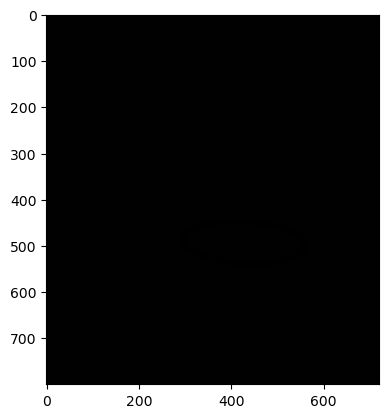

In [129]:
plt.imshow(marker_mask)

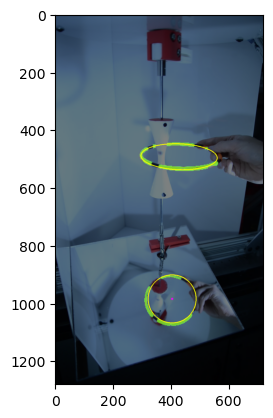

In [102]:
plt.imshow(processed_frame)

In [315]:
cap = cv2.VideoCapture('/Users/jonaheaton/Documents/hulahoop_data/videos/DSC_7450.MOV')

# Get the video's width, height, and frames per second
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or use 'XVID'
os.makedirs('/Users/jonaheaton/Documents/hulahoop_data/output', exist_ok=True)
out = cv2.VideoWriter('/Users/jonaheaton/Documents/hulahoop_data/output/output_DSC_7450.mp4', fourcc, fps, (width, height))

ellipse_coor_list = []
top_marker_coor_list = []
bottom_marker_coor_list = []

max_frames = 200
iter = 0
try:
    while iter < max_frames:
        # Read the next frame
        ret, frame = cap.read()
        if not ret:
            # We reached the end of the video
            break

        # Process the frame
        frame = basic_process_frame(frame)
        processed_frame, coordinate_dict = process_frame(frame)
        ellipse_coor, top_marker_coor, bottom_marker_coor = parse_coordinate_dict(coordinate_dict,iter)

        ellipse_coor_list.append(ellipse_coor)
        top_marker_coor_list.append(top_marker_coor)
        bottom_marker_coor_list.append(bottom_marker_coor)
        # convert the frame back to BGR
        processed_frame = cv2.cvtColor(processed_frame, cv2.COLOR_RGB2BGR)

        # Write the processed frame to the new video file
        out.write(processed_frame)
        iter += 1
        # You can add code here to do something with the processed frame

except Exception as e:
    print(f"An error occurred: {e}")
    print(f"Processed {iter} frames")

finally:
    # Release the video capture and writer objects
    cap.release()
    out.release()

In [316]:
def unstack_marker_coor_list(marker_coor_list):
    marker_coor_dict = {}
    for coor in marker_coor_list:
        for key, value in coor.items():
            if key not in marker_coor_dict:
                marker_coor_dict[key] = []
            marker_coor_dict[key].extend(value)
    return marker_coor_dict

In [317]:
import pandas as pd
ellipse_df = pd.DataFrame(ellipse_coor_list)
top_marker_df = pd.DataFrame(unstack_marker_coor_list(top_marker_coor_list))
bottom_marker_df = pd.DataFrame(unstack_marker_coor_list(bottom_marker_coor_list))

In [319]:
import trackpy as tp

In [374]:
# Link the coordinates
top_linked_df = tp.link_df(top_marker_df, search_range=300, memory=10,pos_columns=['top_markers_x', 'top_markers_y'],
                       t_column='frame')

top_linked_df = tp.filter_stubs(top_linked_df, 10)

print(top_linked_df['particle'].nunique())


Frame 199: 4 trajectories present.
5
5


In [377]:
bottom_linked_df = tp.link_df(bottom_marker_df, search_range=300, memory=10,pos_columns=['bottom_markers_x', 'bottom_markers_y'],
                          t_column='frame')

bottom_linked_df = tp.filter_stubs(bottom_linked_df, 10)

print(bottom_linked_df['particle'].nunique())

Frame 199: 4 trajectories present.
9


In [397]:
import colorsys
def particle_num_to_rgb(num, max_particles):
    '''
    Given a particle number and the max number of particles
    return a color in RGB
    '''
    hue = num / max_particles
    r, g, b = colorsys.hsv_to_rgb(hue, 1, 1)
    return (int(r * 255), int(g * 255), int(b * 255))

In [392]:
particle_num_to_rgb(0,10)

[255, 0, 0]

In [401]:
cap = cv2.VideoCapture('/Users/jonaheaton/Documents/hulahoop_data/videos/DSC_7450.MOV')

# Get the video's width, height, and frames per second
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or use 'XVID'
os.makedirs('/Users/jonaheaton/Documents/hulahoop_data/output', exist_ok=True)
out = cv2.VideoWriter('/Users/jonaheaton/Documents/hulahoop_data/output/output_DSC_7450_particle.mp4', fourcc, fps, (width, height))

ellipse_coor_list = []
top_marker_coor_list = []
bottom_marker_coor_list = []

max_frames = 200
iter = 0
px_sz = 5

try:
    while iter < max_frames:
        # Read the next frame
        ret, frame = cap.read()
        if not ret:
            # We reached the end of the video
            break

        # Process the frame
        frame = basic_process_frame(frame)
        top_half, bottom_half = split_frame(frame)
        frame_data_top = top_linked_df[top_linked_df['frame'] == iter]
        frame_data_bottom = bottom_linked_df[bottom_linked_df['frame'] == iter]

        # color the top markers by particle
        top_overlay = top_half.copy()
        for particle in frame_data_top['particle'].unique():
            particle_data = frame_data_top[frame_data_top['particle'] == particle]
            x = particle_data['top_markers_x'].values[0]
            y = particle_data['top_markers_y'].values[0]
            top_overlay[int(y)-px_sz:int(y)+px_sz, int(x)-px_sz:int(x)+px_sz] = particle_num_to_rgb(particle, top_linked_df['particle'].nunique())


        # color the bottom markers by particle
        bottom_overlay = bottom_half.copy()
        for particle in frame_data_bottom['particle'].unique():
            particle_data = frame_data_bottom[frame_data_bottom['particle'] == particle]
            x = particle_data['bottom_markers_x'].values[0]
            y = particle_data['bottom_markers_y'].values[0]
            bottom_overlay[int(y)-px_sz:int(y)+px_sz, int(x)-px_sz:int(x)+px_sz] = particle_num_to_rgb(particle, bottom_linked_df['particle'].nunique())

        combined_overlay = np.vstack([top_overlay, bottom_overlay])

        # convert the frame back to BGR
        combined_overlay = cv2.cvtColor(combined_overlay, cv2.COLOR_RGB2BGR)

        # Write the processed frame to the new video file
        out.write(combined_overlay)

        iter += 1

except Exception as e:
    print(f"An error occurred: {e}")
    print(f"Processed {iter} frames")

finally:
    # Release the video capture and writer objects
    cap.release()
    out.release()


In [399]:
frame = basic_process_frame(frame)
top_half, bottom_half = split_frame(frame)
frame_data_top = top_linked_df[top_linked_df['frame'] == iter]
frame_data_bottom = bottom_linked_df[bottom_linked_df['frame'] == iter]

# color the top markers by particle
top_overlay = top_half.copy()
for particle in frame_data_top['particle'].unique():
    particle_data = frame_data_top[frame_data_top['particle'] == particle]
    x = particle_data['top_markers_x'].values[0]
    y = particle_data['top_markers_y'].values[0]
    top_overlay[int(y), int(x)] = particle_num_to_rgb(particle, top_linked_df['particle'].nunique())

# color the bottom markers by particle
bottom_overlay = bottom_half.copy()
for particle in frame_data_bottom['particle'].unique():
    particle_data = frame_data_bottom[frame_data_bottom['particle'] == particle]
    x = particle_data['bottom_markers_x'].values[0]
    y = particle_data['bottom_markers_y'].values[0]
    bottom_overlay[int(y), int(x)] = particle_num_to_rgb(particle, bottom_linked_df['particle'].nunique())

combined_overlay = np.vstack([top_overlay, bottom_overlay])

# convert the frame back to BGR
combined_overlay = cv2.cvtColor(combined_overlay, cv2.COLOR_RGB2BGR)

## Next step

we want to improve the parser:
- each marker should have four coordinates from top and bottom. that means we need to link the top and bottom on each frame

how to do this?
we use the ellipse coordinates
one marker is below (x,y) of ellipse  
one marker is above (x,y) of ellipse
one marker is above x and below y of ellipse
one marker is below x and above y of ellipse

having four coordinates should improve the accuracy of the tracking

if a marker is missing, we can estimate its location using the ellipse coordinates and the location of the other markers

In [395]:
top_overlay

array([[[100, 147, 208],
        [100, 147, 208],
        [100, 147, 208],
        ...,
        [ 53,  92, 133],
        [ 53,  92, 133],
        [ 53,  92, 133]],

       [[100, 147, 208],
        [100, 147, 208],
        [100, 147, 208],
        ...,
        [ 53,  92, 133],
        [ 53,  92, 133],
        [ 53,  92, 133]],

       [[101, 148, 209],
        [101, 148, 209],
        [101, 148, 209],
        ...,
        [ 53,  92, 133],
        [ 53,  92, 133],
        [ 53,  92, 133]],

       ...,

       [[168, 227, 255],
        [164, 223, 255],
        [156, 210, 255],
        ...,
        [ 10,  25,  38],
        [  9,  24,  37],
        [  9,  24,  37]],

       [[168, 227, 255],
        [165, 224, 255],
        [158, 212, 255],
        ...,
        [ 11,  24,  38],
        [ 10,  23,  37],
        [ 10,  23,  37]],

       [[168, 227, 255],
        [166, 225, 255],
        [160, 214, 255],
        ...,
        [ 11,  24,  38],
        [ 10,  23,  37],
        [  9,  22,  36]]

In [389]:
particle_num_to_rgb(0,10)

(255, 0, 0)

In [383]:
import imageio
import trackpy as tp
import matplotlib.pyplot as plt

# Create a list to store the frames
frames = []

# Loop over each frame
for frame_num in [30,31,32,33]:
# for frame_num in sorted(top_linked_df['frame'].unique()):
    # Select the data for the current frame
    frame_data_top = top_linked_df[top_linked_df['frame'] == frame_num]
    frame_data_bottom = bottom_linked_df[bottom_linked_df['frame'] == frame_num]
    frame_data_top.rename(columns={'top_markers_x': 'x', 'top_markers_y': 'y'}, inplace=True)
    frame_data_bottom.rename(columns={'bottom_markers_x': 'x', 'bottom_markers_y': 'y'}, inplace=True)
    # Create a figure and axes
    fig, ax = plt.subplots()

    # Draw the particles
    tp.annotate(frame_data_top, image, ax=ax)
    tp.annotate(frame_data_bottom, image, ax=ax)

    # Remove the axes
    plt.axis('off')

    # Save the figure to a temporary file and add it to the frames list
    tmpfile = 'tmp.png'
    plt.savefig(tmpfile, bbox_inches='tight', pad_inches=0)
    frames.append(imageio.imread(tmpfile))

    # Close the figure
    plt.close(fig)

# Save the frames as a movie
imageio.mimsave('~/Desktop/tp_movie.mp4', frames, format='mp4')

/var/folders/wl/x58pc4s51gl9xvvgmg5q2wxm0000gn/T/ipykernel_82433/2233827810.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_data_top.rename(columns={'top_markers_x': 'x', 'top_markers_y': 'y'}, inplace=True)
/var/folders/wl/x58pc4s51gl9xvvgmg5q2wxm0000gn/T/ipykernel_82433/2233827810.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_data_bottom.rename(columns={'bottom_markers_x': 'x', 'bottom_markers_y': 'y'}, inplace=True)
/var/folders/wl/x58pc4s51gl9xvvgmg5q2wxm0000gn/T/ipykernel_82433/2233827810.py:29: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that o

In [369]:
import trackpy as tp

# Filter out trajectories less than 4 frames in length
filtered_df = tp.filter_stubs(linked_df, 10)

# Print the filtered DataFrame
print(filtered_df)

       frame  top_markers_x  top_markers_y  top_markers_area  particle
frame                                                                 
0          0     496.306554     455.784355               473         0
0          0     329.790875     461.110266               263         1
0          0     566.523438     508.335938               128         2
0          0     345.846827     521.870897               457         3
1          1     496.617954     456.027140               479         0
...      ...            ...            ...               ...       ...
198      198     366.354610     532.673759               141         2
199      199     321.251397     529.346369               179         2
199      199     611.347032     570.479452               219         4
199      199     452.239075     505.776350               389         1
199      199     478.263889     620.652778               720         3

[692 rows x 5 columns]


In [370]:
filtered_df['particle'].nunique()

5

<Axes: xlabel='frame'>

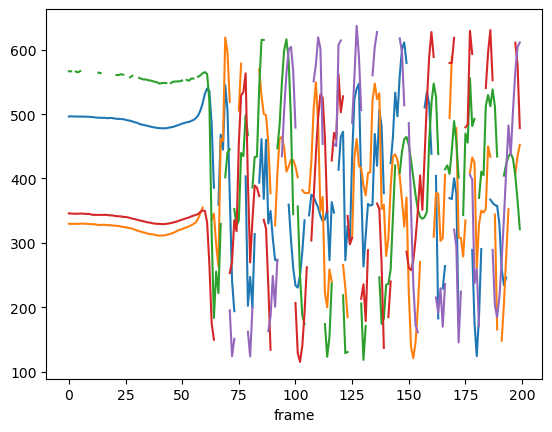

In [371]:
particle_y= filtered_df.pivot(index='frame', columns='particle', values='top_markers_y')
particle_x = filtered_df.pivot(index='frame', columns='particle', values='top_markers_x')

particle_x.plot(legend=False)

In [357]:
filtered_df.pivot(index='frame', columns='particle', values='top_markers_x')

particle,0,1,2,3,4,5,7
frame,,,,,,,
0,496.306554,329.790875,566.523438,345.846827,NaN,NaN,NaN
1,496.617954,329.458333,566.528846,345.531729,NaN,NaN,NaN
2,496.339869,329.549828,NaN,345.297727,NaN,NaN,NaN
3,496.340564,329.652482,566.186916,345.157080,NaN,NaN,NaN
4,496.149160,329.417582,564.830357,345.344298,NaN,NaN,NaN
...,...,...,...,...,...,...,...
195,439.506306,NaN,NaN,NaN,436.274882,NaN,NaN
196,430.485714,NaN,NaN,NaN,506.264840,NaN,NaN
197,405.168203,NaN,NaN,610.939535,565.635193,407.236994,NaN


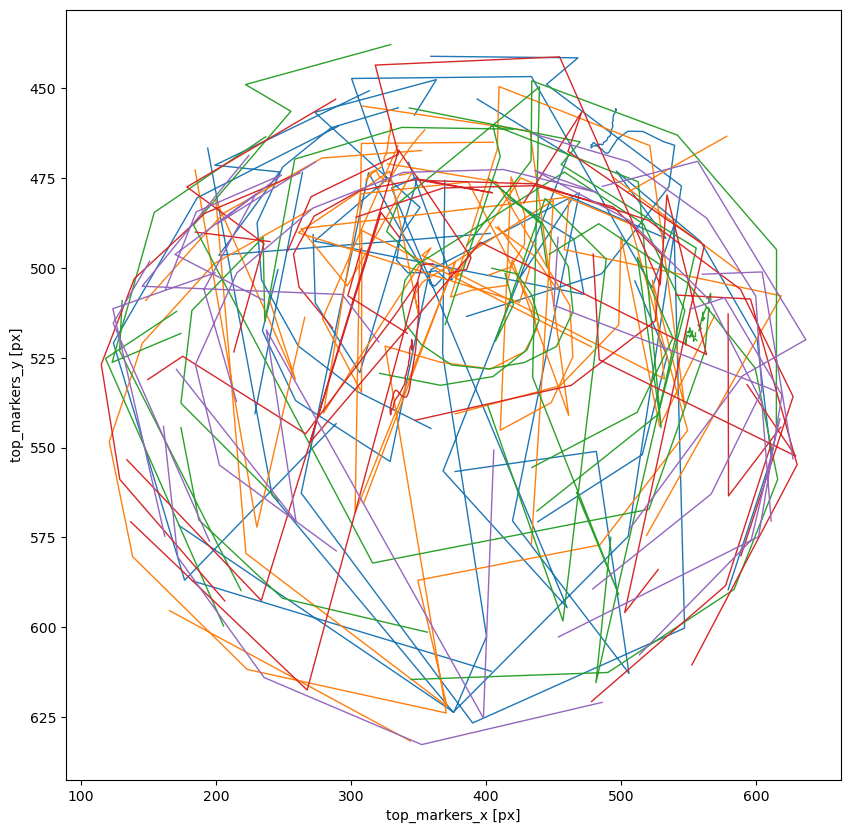

In [372]:
import matplotlib.pyplot as plt
import trackpy as tp

# Plot the trajectories
plt.figure(figsize=(10, 10))
tp.plot_traj(filtered_df,pos_columns=['top_markers_x', 'top_markers_y'], t_column='frame')

plt.show()

In [ ]:
# how best to visualize the linked_df

In [336]:
linked_df['particle']

0       0
1       1
2       2
3       3
4       0
       ..
685    23
689    23
690    21
688    27
691    28
Name: particle, Length: 692, dtype: int64

In [318]:
top_marker_df

,frame,top_markers_x,top_markers_y,top_markers_area
0,0.0,496.306554,455.784355,473
1,0.0,329.790875,461.110266,263
2,0.0,566.523438,508.335938,128
3,0.0,345.846827,521.870897,457
4,1.0,496.617954,456.027140,479
...,...,...,...,...
687,198.0,577.604651,588.414729,516
688,199.0,452.239075,505.776350,389
689,199.0,321.251397,529.346369,179
690,199.0,611.347032,570.479452,219


In [312]:
marker_df = pd.DataFrame(marker_coor_list_2)

ValueError: All arrays must be of the same length

In [300]:
marker_coor_list[0]

{'frame': 0,
 'top_markers_x': [496.30655391120507,
  329.7908745247148,
  566.5234375,
  345.8468271334792],
 'top_markers_y': [455.784355179704,
  461.1102661596958,
  508.3359375,
  521.870897155361],
 'bottom_markers_x': [357.77464788732397,
  447.3076923076923,
  480.63157894736844,
  477.27878787878785,
  346.06607929515417],
 'bottom_markers_y': [117.84507042253522,
  120.94871794871794,
  176.31578947368422,
  227.65454545454546,
  251.5286343612335],
 'top_markers_area': array([473, 263, 128, 457], dtype=int32),
 'bottom_markers_area': array([ 71, 234,  57, 165, 227], dtype=int32)}

In [299]:
ellipse_df

,frame,top_ellipse_x,top_ellipse_y,bottom_ellipse_x,bottom_ellipse_y
0,0,429.069275,493.483002,399.690613,190.788925
1,1,428.927307,493.239777,399.208923,190.624878
2,2,429.514008,492.881653,399.914276,190.209686
3,3,428.753265,493.108307,399.013580,189.822830
4,4,429.535431,493.462189,399.959991,189.753250
...,...,...,...,...,...
195,195,436.470825,493.946106,408.512878,101.618088
196,196,479.211609,507.139374,435.233459,125.613945
197,197,499.607483,524.108643,448.381012,159.513351
198,198,495.176849,543.836060,444.507782,196.292572


In [111]:
frame = basic_process_frame(frame)

In [112]:
top_half, bottom_half = split_frame(frame)

top_hoop_mask = get_orange_hoop_mask(top_half)
bottom_hoop_mask = get_orange_hoop_mask(bottom_half)

# bottom_circle = get_hoop_circle_from_mask(bottom_hoop_mask)
bottom_circle=fit_ellipse_to_disjoint_masks(bottom_hoop_mask,min_area=20)
top_ellipse = fit_ellipse_to_disjoint_masks(top_hoop_mask)

In [113]:
bottom_circle

((293.271728515625, 193.62986755371094),
 (379.4150085449219, 538.5745239257812),
 99.91206359863281)